In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_matrix(m, r, seed):
    """
    Generate a synthetic nonnegative matrix X = X1 @ X2
    """
    np.random.seed(seed)
    X1 = np.abs(np.random.randn(m, r))
    X2 = np.abs(np.random.randn(r, m))
    return X1 @ X2

def NMF(V, r, solver, seed,
        max_iter=200, eps=1e-9,
        record_error=True):
    """
    Generic NMF framework using the provided solver (e.g., ALS).
    """
    rng = np.random.default_rng(seed)
    m, n = V.shape
    W = np.maximum(rng.random((m, r)), eps)
    H = np.maximum(rng.random((r, n)), eps)

    errors = []

    for t in range(max_iter):
        W, H = solver(V, W, H, eps=eps)
        if record_error:
            err = np.linalg.norm(V - W @ H, 'fro')**2
            errors.append(err)

    return W, H, errors

def plot_error(errors, label=None):
    """
    Plot reconstruction error vs iteration.
    
    Parameters
    ----------
    errors : list or array
        Error values recorded during NMF iterations.
    label : str
        Label for legend (optional).
    """
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(errors) + 1), errors,
             marker='o', linewidth=1.8, label=label)
    
    plt.xlabel("Iteration")
    plt.ylabel("Reconstruction Error (Frobenius norm)")
    plt.title("NMF Convergence")
    plt.grid(True, linestyle='--', alpha=0.6)

    if label:
        plt.legend()

    plt.show()


In [3]:
def ALS_stable(V, W, H, eps=1e-9):
    """
    A more stable ALS update:
    - Least squares updates
    - Projection to nonnegativity
    - Column normalization of W
    - Rescaling of H to match
    """

    r = W.shape[1]

    # === Update H ===
    WtW = W.T @ W + eps * np.eye(r)
    H = np.linalg.solve(WtW, W.T @ V)
    H = np.maximum(H, 0)

    # === Update W ===
    HHt = H @ H.T + eps * np.eye(r)
    W = (V @ H.T) @ np.linalg.inv(HHt)
    W = np.maximum(W, 0)

    # === Normalize W columns to avoid exploding scales ===
    norms = np.linalg.norm(W, axis=0)
    norms = np.maximum(norms, eps)   # avoid divide by zero
    W = W / norms
    H = H * norms[:, None]           # scale H to keep WH unchanged

    return W, H


In [4]:
def mult_update_step(V, W, H, eps=1e-9):
    """
    One multiplicative update iteration for NMF.
    Matches the structure of the ALS solver so it can be used inside NMF().
    """
    # Update W (A in your code)
    W = W * ((V @ H.T) / (W @ (H @ H.T) + eps))

    # Update H (S in your code)
    H = H * ((W.T @ V) / (W.T @ (W @ H) + eps))

    return W, H


In [13]:
# ===== CALL CELL =====

# Generate matrix using today's date as seed
seed_today = 11132025
X = generate_matrix(m=100, r=5, seed=seed_today)

# Same initialization for both algorithms
seed_nmf = seed_today // 2

# Run stable ALS
_, _, errs_als = NMF(X, r=5, solver=ALS_stable,
                     seed=seed_nmf, max_iter=50)

# Run multiplicative update
_, _, errs_mu = NMF(X, r=5, solver=mult_update_step,
                    seed=seed_nmf, max_iter=50)

# Print some diagnostic values
print("ALS_stable final error:", errs_als[-1])
print("MU final error:", errs_mu[-1])
print("ALS_stable first 5 errors:", errs_als[:5])
print("MU first 5 errors:", errs_mu[:5])


ALS_stable final error: 21.135005292977244
MU final error: 1407.6587693912015
ALS_stable first 5 errors: [1144697.875642816, 7004.441616161894, 2607.6066580491206, 1721.489000474982, 1367.5613478718733]
MU first 5 errors: [9011.247909753973, 8266.903480399593, 7777.50958279315, 7403.528266656971, 7108.420600361319]


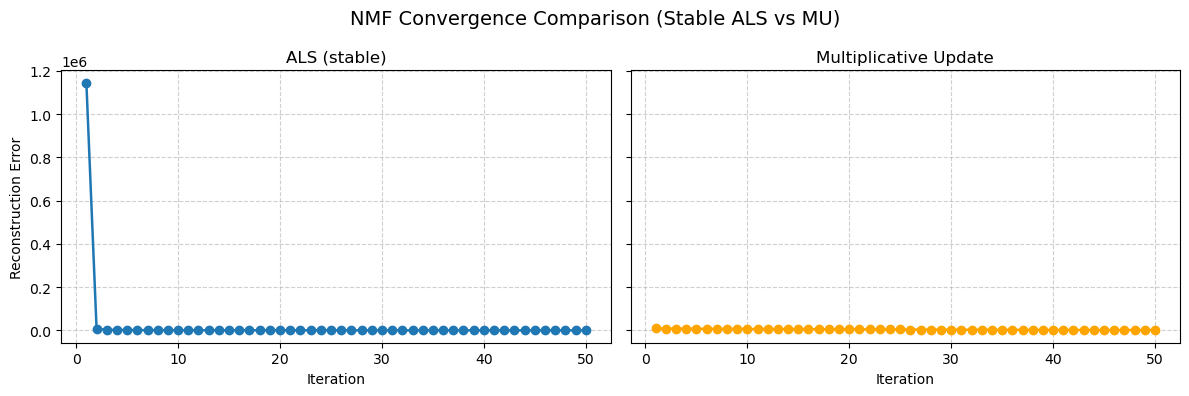

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# ALS stable
axes[0].plot(range(1, len(errs_als)+1), errs_als,
             marker='o', linewidth=1.8, label="ALS-stable")
axes[0].set_title("ALS (stable)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Reconstruction Error")
axes[0].grid(True, linestyle='--', alpha=0.6)

# MU
axes[1].plot(range(1, len(errs_mu)+1), errs_mu,
             marker='o', linewidth=1.8, color='orange', label="MU")
axes[1].set_title("Multiplicative Update")
axes[1].set_xlabel("Iteration")
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.suptitle("NMF Convergence Comparison (Stable ALS vs MU)", fontsize=14)
plt.tight_layout()
plt.show()


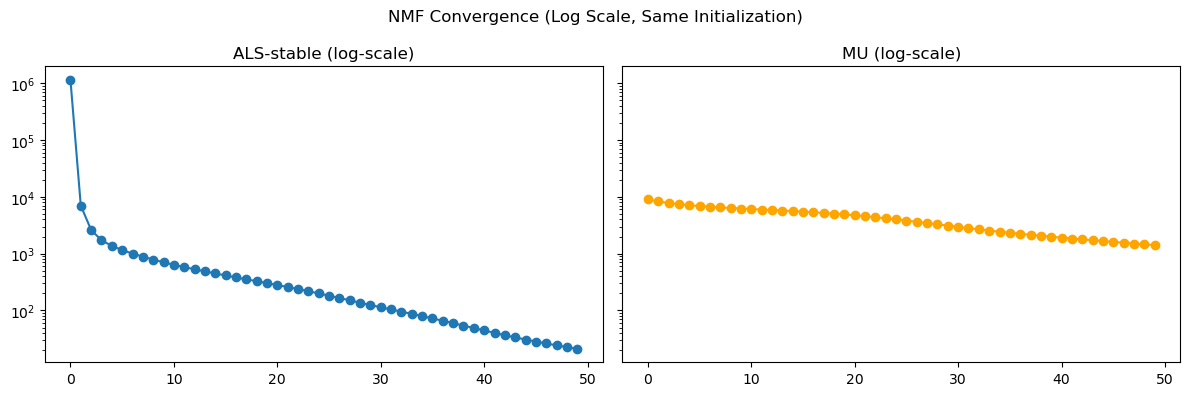

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].plot(errs_als, marker='o')
axes[0].set_yscale('log')
axes[0].set_title("ALS-stable (log-scale)")

axes[1].plot(errs_mu, marker='o', color='orange')
axes[1].set_yscale('log')
axes[1].set_title("MU (log-scale)")

plt.suptitle("NMF Convergence (Log Scale, Same Initialization)")
plt.tight_layout()
plt.show()


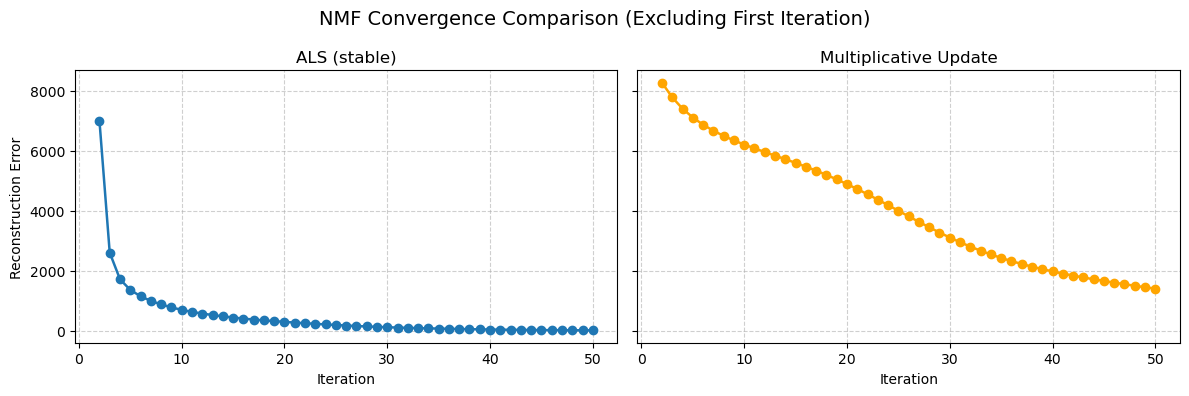

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

iters_als = range(2, len(errs_als) + 1)
iters_mu  = range(2, len(errs_mu) + 1)

# ALS stable
axes[0].plot(iters_als, errs_als[1:], marker='o', linewidth=1.8, label="ALS-stable")
axes[0].set_title("ALS (stable)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Reconstruction Error")
axes[0].grid(True, linestyle='--', alpha=0.6)

# MU
axes[1].plot(iters_mu, errs_mu[1:], marker='o', linewidth=1.8, color='orange', label="MU")
axes[1].set_title("Multiplicative Update")
axes[1].set_xlabel("Iteration")
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.suptitle("NMF Convergence Comparison (Excluding First Iteration)", fontsize=14)
plt.tight_layout()
plt.show()


Coodinate descent

In [18]:
def HALS_step(V, W, H, eps=1e-9):
    """
    One HALS (coordinate descent) update for NMF.
    Updates one column of W and one row of H at a time.
    """
    m, r = W.shape
    r, n = H.shape

    # Precompute useful matrices
    VV = V.copy()
    HHt = H @ H.T
    WtW = W.T @ W

    # === Update H row-by-row ===
    WH = W @ H
    for k in range(r):
        # residual excluding component k
        Hk = H[k, :] + (W[:, k].T @ (V - WH)) / (np.linalg.norm(W[:, k])**2 + eps)
        H[k, :] = np.maximum(Hk, 0)
        WH = W @ H   # update WH incrementally

    # === Update W column-by-column ===
    WH = W @ H
    for k in range(r):
        Wk = W[:, k] + ((V - WH) @ H[k, :].T) / (np.linalg.norm(H[k, :])**2 + eps)
        W[:, k] = np.maximum(Wk, 0)
        WH = W @ H

    return W, H


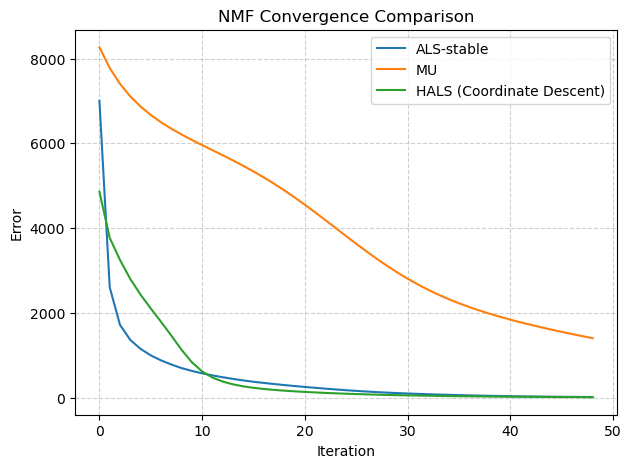

In [19]:
seed_today = 11132025
X = generate_matrix(m=100, r=5, seed=seed_today)
seed_nmf = seed_today // 2

# ALS stable
_, _, errs_als = NMF(X, r=5, solver=ALS_stable, seed=seed_nmf, max_iter=50)

# multiplicative update
_, _, errs_mu  = NMF(X, r=5, solver=mult_update_step, seed=seed_nmf, max_iter=50)

# HALS coordinate descent
_, _, errs_hals = NMF(X, r=5, solver=HALS_step, seed=seed_nmf, max_iter=50)

# Plot all three
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(errs_als[1:], label="ALS-stable")
ax.plot(errs_mu[1:], label="MU")
ax.plot(errs_hals[1:], label="HALS (Coordinate Descent)")
ax.set_xlabel("Iteration")
ax.set_ylabel("Error")
ax.set_title("NMF Convergence Comparison")
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend()
plt.show()
